# This noteboook is aimed at modelling returns of Bitcoin using traditional econometrics approach

## Importing libraries

In [1]:
# basic data-handling libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# libraries used in dataimports and modifications
from tvDatafeed import TvDatafeed, Interval
import pandas_ta as ta
import requests
import json
import datetime

In [3]:
# library for statistical analysis
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [4]:
# utilities
import sys
import nltk
sys.path.append('modules')
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kotakikuchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing data

In [10]:
bitcoin = utils.get_data('BTCUSDT', exchange = 'BINANCE',start_date = "2020-01-01", end_date = '2021-12-31')

twitter_sentiment = pd.read_pickle('../data/cleaned/by_date_verified_weighted_sentiment_2020-2021.pkl')
twitter_price_opinion = pd.read_pickle('../data/cleaned/by_date_verified_weighted_money_2020-2021.pkl')
twitter_price_opinion_normalized =  pd.read_pickle('../data/cleaned/by_date_normalized_money_2020-2021.pkl')
twitter_price_opinion_normalized['created_at'] = pd.to_datetime(twitter_price_opinion_normalized['created_at'])

# merging the data based on datetime with how = 'outer' as we would like to cover all the dates during 2020-2021 .
merged_df = bitcoin.merge(twitter_sentiment, how = 'outer', left_on = 'datetime', right_on = 'created_at').drop(columns = 'created_at')\
            .merge(twitter_price_opinion_normalized, how = 'outer', left_on = 'datetime', right_on = 'created_at')



In [11]:
print(f"N rows bitcoin: {len(bitcoin)}")
print(f"N rows twitter_sentiment: {len(twitter_sentiment)}")
print(f"N rows twitter_price_opinion: {len(twitter_price_opinion)}")
print(f"N rows twitter_price_opinion_normalized: {len(twitter_price_opinion_normalized)}")
print(f"N rows merged_df: {len(merged_df)}")

N rows bitcoin: 731
N rows twitter_sentiment: 731
N rows twitter_price_opinion: 731
N rows twitter_price_opinion_normalized: 724
N rows merged_df: 731


In [12]:
merged_df.head()

,datetime,symbol,open,high,low,close,volume,weighted_sentiment,created_at,normalized_money
0,2020-01-01,BINANCE:BTCUSDT,7200.77,7212.50,6924.74,6965.71,31951.483932,0.126772,2020-01-01,-1.732184
1,2020-01-02,BINANCE:BTCUSDT,6965.49,7405.00,6871.04,7344.96,68428.500451,0.073418,2020-01-02,-2.153626
2,2020-01-03,BINANCE:BTCUSDT,7345.00,7404.00,7272.21,7354.11,29987.974977,0.145800,2020-01-03,-1.508160
3,2020-01-04,BINANCE:BTCUSDT,7354.19,7495.00,7318.00,7358.75,38331.085604,0.087736,2020-01-04,-2.642491
4,2020-01-05,BINANCE:BTCUSDT,7357.64,7795.34,7346.76,7758.00,54635.695316,0.057072,2020-01-05,-1.754553


## Linear Regression

In [13]:
# preparing dataframe, specifically, lagging columns or calculating returns
merged_df = utils.lag_columns(merged_df, ['weighted_sentiment', 'normalized_money'], +1)
merged_df = utils.calculate_return(merged_df, ['close'], 1)


### We need to lag the features to avoid leakage (lookahead bias). That is, you cannot use tomorrow's data to predict the price for tomorrow. We need to use what we know today to predict the price tomorrow.

- Therefore, in the analyis, we use today's feature to explain the return on tomorrow. That is, home much change in price will occur from today's closing price till tommorow's closing price.

In [17]:
merged_df.head()

,datetime,symbol,open,high,low,close,volume,weighted_sentiment,created_at,normalized_money,weighted_sentiment_1_days_lagged,normalized_money_1_days_lagged,close_return
0,2020-01-01,BINANCE:BTCUSDT,7200.77,7212.50,6924.74,6965.71,31951.483932,0.126772,2020-01-01,-1.732184,NaN,NaN,NaN
1,2020-01-02,BINANCE:BTCUSDT,6965.49,7405.00,6871.04,7344.96,68428.500451,0.073418,2020-01-02,-2.153626,0.126772,-1.732184,0.054445
2,2020-01-03,BINANCE:BTCUSDT,7345.00,7404.00,7272.21,7354.11,29987.974977,0.145800,2020-01-03,-1.508160,0.073418,-2.153626,0.001246
3,2020-01-04,BINANCE:BTCUSDT,7354.19,7495.00,7318.00,7358.75,38331.085604,0.087736,2020-01-04,-2.642491,0.145800,-1.508160,0.000631
4,2020-01-05,BINANCE:BTCUSDT,7357.64,7795.34,7346.76,7758.00,54635.695316,0.057072,2020-01-05,-1.754553,0.087736,-2.642491,0.054255


<AxesSubplot:ylabel='Frequency'>

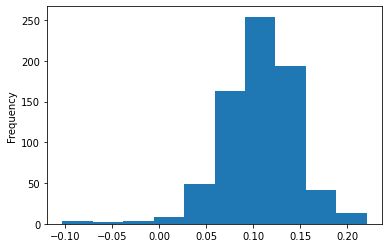

In [18]:
merged_df['weighted_sentiment_1_days_lagged'].plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

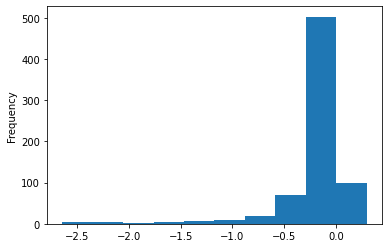

In [19]:
merged_df['normalized_money_1_days_lagged'].plot(kind = 'hist')

**Correlation sentiment and return on bitcoin**

- We expect to observe a positive relationship between Bitcoin return and sentiment

In [20]:
formula_1 = 'close_return ~ weighted_sentiment_1_days_lagged '
res_1 = ols(formula_1, data= merged_df).fit()

In [21]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:           close_return   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.118
Date:                Sun, 13 Mar 2022   Prob (F-statistic):             0.0428
Time:                        15:19:57   Log-Likelihood:                 1298.3
No. Observations:                 730   AIC:                            -2593.
Df Residuals:                     728   BIC:                            -2583.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [22]:
print(res_1.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                       &  close\_return   & \textbf{  R-squared:         } &     0.006   \\
\textbf{Model:}                               &       OLS        & \textbf{  Adj. R-squared:    } &     0.004   \\
\textbf{Method:}                              &  Least Squares   & \textbf{  F-statistic:       } &     4.118   \\
\textbf{Date:}                                & Sun, 13 Mar 2022 & \textbf{  Prob (F-statistic):} &   0.0428    \\
\textbf{Time:}                                &     15:20:01     & \textbf{  Log-Likelihood:    } &    1298.3   \\
\textbf{No. Observations:}                    &         730      & \textbf{  AIC:               } &    -2593.   \\
\textbf{Df Residuals:}                        &         728      & \textbf{  BIC:               } &    -2583.   \\
\textbf{Df Model:}                            &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}         

**Correlation between price opinion and bitcoin return**

- We expect to observe a positive relationship with Bitcoin price opinion and Bitcoin return.

In [23]:
formula_2 = 'close_return ~ normalized_money_1_days_lagged'
res_2 = ols(formula_2, data= merged_df).fit()

In [24]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:           close_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.009974
Date:                Sun, 13 Mar 2022   Prob (F-statistic):              0.920
Time:                        15:20:43   Log-Likelihood:                 1282.9
No. Observations:                 723   AIC:                            -2562.
Df Residuals:                     721   BIC:                            -2553.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [25]:
print(res_2.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                     &  close\_return   & \textbf{  R-squared:         } &     0.000   \\
\textbf{Model:}                             &       OLS        & \textbf{  Adj. R-squared:    } &    -0.001   \\
\textbf{Method:}                            &  Least Squares   & \textbf{  F-statistic:       } &  0.009974   \\
\textbf{Date:}                              & Sun, 13 Mar 2022 & \textbf{  Prob (F-statistic):} &    0.920    \\
\textbf{Time:}                              &     15:20:47     & \textbf{  Log-Likelihood:    } &    1282.9   \\
\textbf{No. Observations:}                  &         723      & \textbf{  AIC:               } &    -2562.   \\
\textbf{Df Residuals:}                      &         721      & \textbf{  BIC:               } &    -2553.   \\
\textbf{Df Model:}                          &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}                   &    n